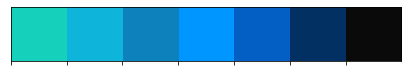

In [1]:
## Improt python libraries 
import os, sys, io
import requests
import pandas as pd
import datetime as dt
from zipfile import ZipFile
import seaborn as sns

## Set custom palette color for diagram
custom_palette = sns.color_palette(["#15d1bb","#0fb4db","#0d81bb","#0096ff","#045fc4","#023062","#0a0a0a"])
sns.palplot(custom_palette)
sns.set_palette(custom_palette)
figure_size = (9,5)

In [2]:
## Function to get bluebike data from s3 bucket 
## Source: https://s3.amazonaws.com/hubway-data/index.html

def getData(begin_year=2021, end_year=2021):

  csv_list = list()
  for year in range(begin_year, end_year + 1):

    for month in range(1,13):
      filename = 'hubway' 
      # since 2018 the company name was changes to bluebike, originally was hubway
      if (year == 2018 and month > 4) or (year > 2018):
            filename = 'bluebikes'
          
      if month < 10: 
        month = str('0' + str(month))
      else:
        month = str(month)
      
      csv_name = '{}{}-{}-tripdata'.format(str(year), month, filename)
      csv_list.append(csv_name)

  output_file = 'bluebikes_tripdata_{}_{}.csv'.format(begin_year, end_year)
  if not os.path.exists(output_file):

      is_header = True
      for csv_name in csv_list:
        zip_file = 'https://s3.amazonaws.com/hubway-data/{}.zip'.format(csv_name)
        try:
          # load data with io/stream directly from internet url 
          load = pd.read_csv(zip_file, dtype = str, chunksize=10000)
        except:
          # in case it is not possible, download it first and then load
          response = requests.get(zip_file)
          zip = ZipFile(io.BytesIO(response.content))
          with zip.open('{}.csv'.format(csv_name), mode="r") as csv_file:
              load = [pd.read_csv(csv_file)]

        # load data into one csv file
        for df in load:
          df.to_csv(output_file, mode='a', index=False, header=is_header)
          if is_header:
              is_header = False
  return pd.read_csv(output_file, index_col=False, dtype='unicode')

In [3]:
## Load bluebike data only from 2021 and cleanup
bluebikes = getData(begin_year=2021, end_year=2021)
bluebikes['starttime'] = pd.to_datetime(bluebikes['starttime'])
bluebikes['only_date'] = pd.to_datetime(bluebikes.starttime.dt.date)
bluebikes['start_station'] = pd.to_numeric(bluebikes['start station id'], downcast='integer')

In [4]:
## Group bluebike data
bluebikes_usertype = bluebikes.groupby([bluebikes['only_date'],bluebikes['usertype']]).size().to_frame('total').reset_index()
bluebikes_usertype = bluebikes_usertype.pivot_table('total', 'only_date', 'usertype').reset_index()
bluebikes_usertype.rename(columns = {'Customer':'customer', 'Subscriber':'subscriber'}, inplace = True)

bluebikes_total = bluebikes.loc[:, ['tripduration','only_date','start_station','usertype']]
bluebikes_total = bluebikes_total.groupby(bluebikes['only_date']).size().to_frame('total').reset_index()

In [5]:
## Load weather data in 2021
## Source: https://meteostat.net/en/place/us/boston
## Uploaded data to Github to make it eaier to resueable 
weather_2021 = pd.read_csv('https://raw.githubusercontent.com/5RK7N/boston-bluebike/main/weather/BostonWeatherData2021.csv', index_col=False, dtype='unicode')

In [6]:
## Cleanup weather data 2021
weather_2021['date'] = pd.to_datetime(weather_2021['date'])
weather_2021['tavg'] = pd.to_numeric(weather_2021['tavg'], downcast='float')
weather_2021['tmin'] = pd.to_numeric(weather_2021['tmin'], downcast='float')
weather_2021['tmax'] = pd.to_numeric(weather_2021['tmax'], downcast='float')
weather_2021['prcp'] = pd.to_numeric(weather_2021['prcp'], downcast='float')
weather_2021['wdir'] = pd.to_numeric(weather_2021['wdir'], downcast='float')
weather_2021['wspd'] = pd.to_numeric(weather_2021['wspd'], downcast='float')
weather_2021['pres'] = pd.to_numeric(weather_2021['pres'], downcast='float')
weather_2021 = weather_2021.loc[:, ['date','tavg','tmin','tmax','prcp','wdir','wspd','pres']]

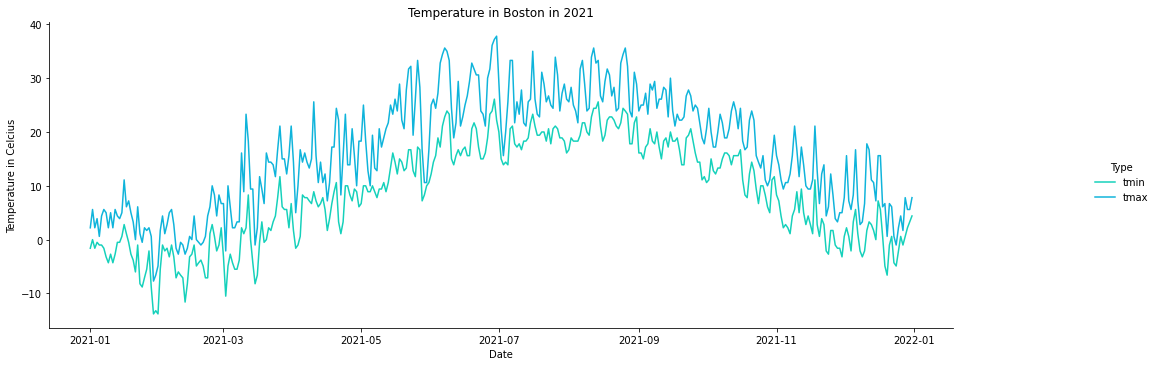

In [7]:
## Show weather over the year in 2021
selected_weather = weather_2021.loc[:, ['date','tmin','tmax']].melt(id_vars=["date"], var_name="Type", value_name="value")
sns.set_palette(custom_palette)
i = sns.relplot(data=selected_weather, x="date", y="value", hue="Type", kind="line").set(title='Temperature in Boston in 2021', xlabel='Date', ylabel='Temperature in Celcius')
i.fig.set_size_inches(18,5)

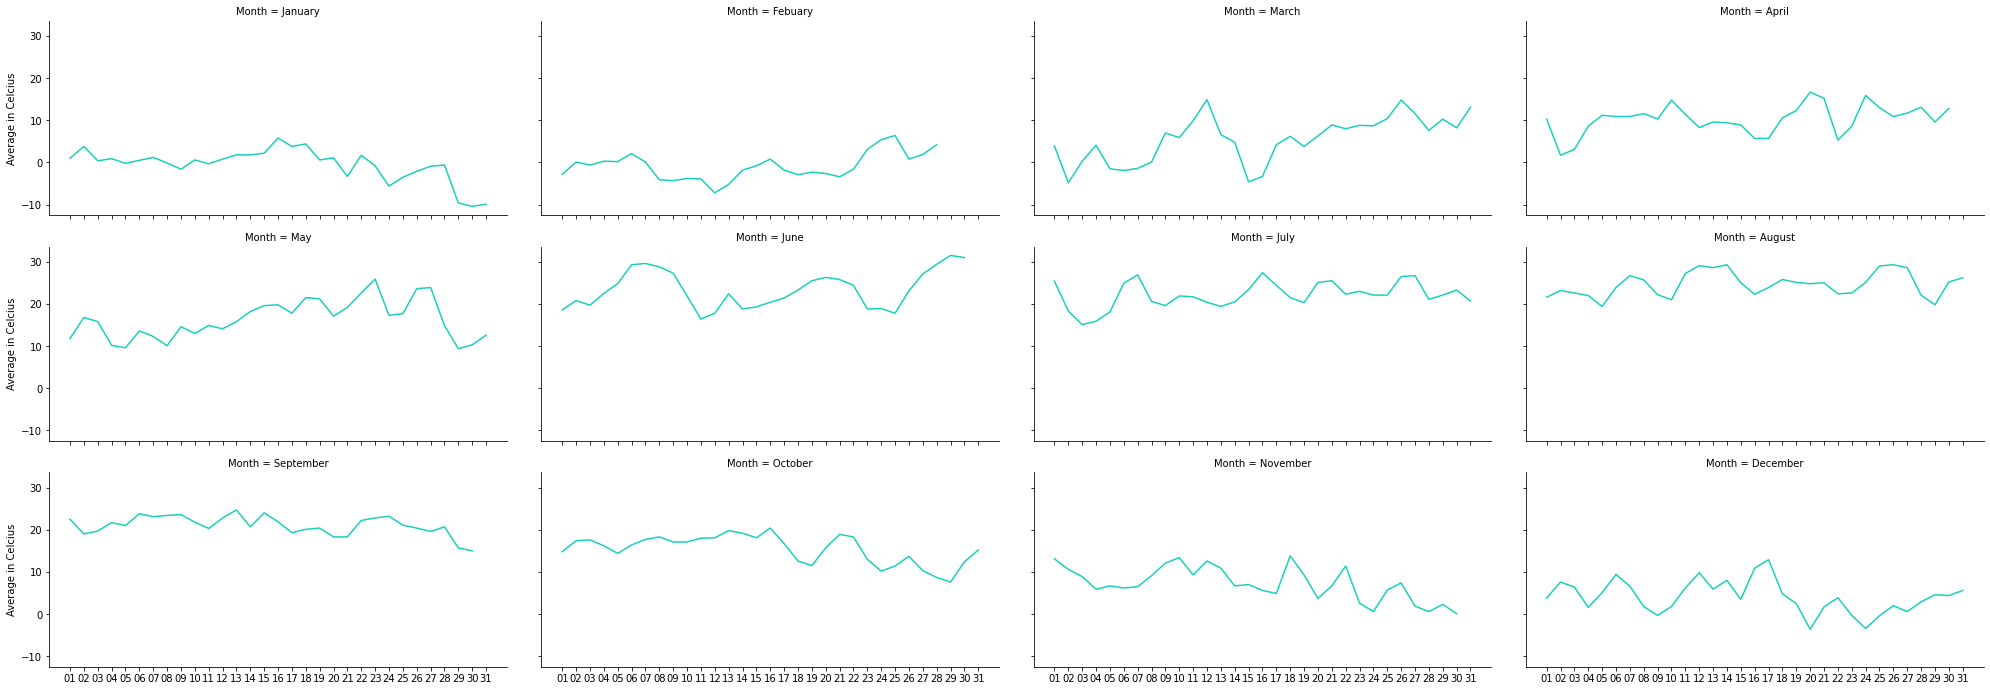

In [8]:
## Function - convert month number to word
def toMonthWord(month):
    monthWord = {1:"January", 2:"Febuary", 3:"March", 4:"April", 5:"May", 6:"June", 7:"July", 8:"August", 9:"September", 10:"October", 11:"November", 12:"December"}
    return monthWord[month]

weather_2021['Month'] = weather_2021.date.dt.month
weather_2021['Month'] = weather_2021['Month'].apply(toMonthWord)
weather_2021['Day'] = weather_2021.date.dt.strftime("%d")

## Show monthly temperature in 2021
k = sns.relplot(data=weather_2021, x="Day", y="tavg", col="Month", col_wrap=4, height=3, kind="line").set(xlabel=None, ylabel='Average in Celcius')
k.fig.set_size_inches(29,10)

In [9]:
## Merge bluebike data and weather data in 2021 together
bluebikes_all = pd.merge(left=bluebikes_total, right=bluebikes_usertype, how='left', left_on='only_date', right_on='only_date')
bluebikes_prediction = pd.merge(left=bluebikes_all, right=weather_2021, how='left', left_on='only_date', right_on='date')
bluebikes_prediction = bluebikes_prediction.loc[:, ['date','total','customer','subscriber','tavg','tmin','tmax','prcp','wdir','wspd','pres']]

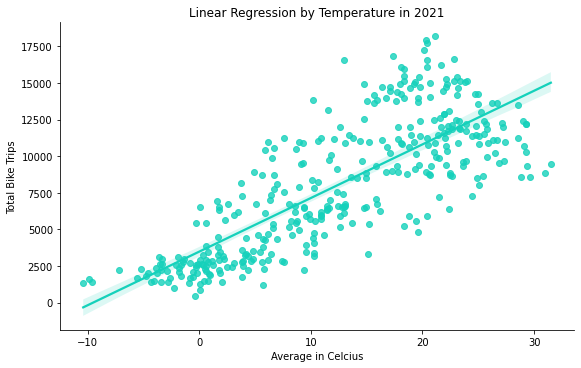

In [10]:
## Plot liner regression for total bike trip by the average temperature in 2021
l = sns.lmplot(data=bluebikes_prediction, x="tavg", y="total").set(title='Linear Regression by Temperature in 2021', xlabel='Average in Celcius', ylabel='Total Bike Trips')
l.fig.set_size_inches(9,5)

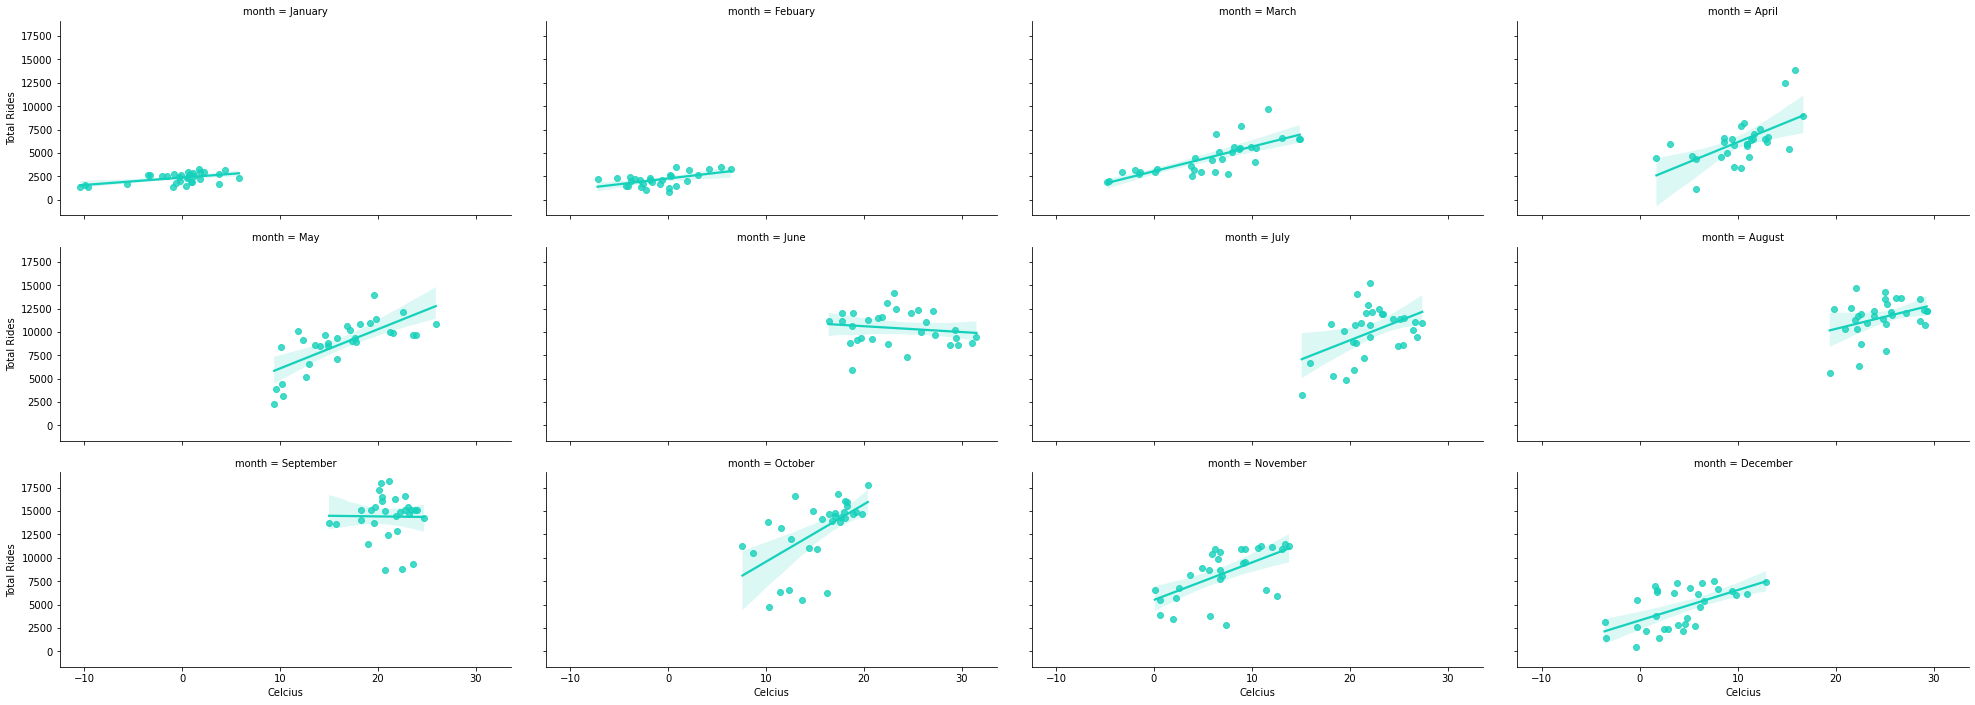

In [11]:
## Plot liner regression for total bike trip by the average temperature (per month) in 2021
bluebikes_prediction['month'] = bluebikes_prediction.date.dt.month
bluebikes_prediction['month'] = bluebikes_prediction['month'].apply(toMonthWord)

k = sns.lmplot(data=bluebikes_prediction, x="tavg", y="total", col="month", col_wrap=4, height=3).set(xlabel='Celcius', ylabel='Total Rides')
k.fig.set_size_inches(29,10)

In [12]:
## Seperate date for prediction
bluebikes_prediction['day'] = bluebikes_prediction.date.dt.dayofweek + 1
bluebikes_prediction['month'] = bluebikes_prediction.date.dt.month

In [13]:
## Show some sample from pre-prediction data which will be used to train the model
bluebikes_prediction.head()

,date,total,customer,subscriber,tavg,tmin,tmax,prcp,wdir,wspd,pres,month,day
0,2021-01-01,1894,643,1251,1.0,-1.6,2.2,2.5,5.0,10.100000,1030.099976,1,5
1,2021-01-02,1720,425,1295,3.8,0.0,5.6,10.4,349.0,23.000000,1011.000000,1,6
2,2021-01-03,1485,254,1231,0.4,-1.6,2.2,0.8,354.0,15.100000,1019.900024,1,7
3,2021-01-04,1923,220,1703,0.9,-0.5,3.9,0.0,1.0,18.400000,1014.599976,1,1
4,2021-01-05,2028,211,1817,-0.2,-1.0,0.6,0.3,343.0,17.299999,1013.000000,1,2


In [14]:
## Show maximum temperature in 2021
bluebikes_prediction['tmax'].max()

37.8

In [15]:
## Show minimum temperature in 2021
bluebikes_prediction['tmin'].min()

-13.8

In [16]:
## Show information of the day that has maximum temperature in 2021
bluebikes_prediction.loc[bluebikes_prediction['tmax']==37.8]

,date,total,customer,subscriber,tavg,tmin,tmax,prcp,wdir,wspd,pres,month,day
180,2021-06-30,8837,2080,6757,31.0,22.200001,37.799999,4.1,237.0,15.8,1013.599976,6,3


In [17]:
## Show information of the day that has minimum temperature in 2021
bluebikes_prediction.loc[bluebikes_prediction['tmin']==-13.8]

,date,total,customer,subscriber,tavg,tmin,tmax,prcp,wdir,wspd,pres,month,day
28,2021-01-29,1371,104,1267,-9.6,-13.8,-7.7,0.0,312.0,33.5,1014.299988,1,5
30,2021-01-31,1577,218,1359,-9.9,-13.8,-4.9,0.0,349.0,9.4,1026.800049,1,7


In [18]:
## Show minimum total rides in 2021
bluebikes_prediction['total'].min()

466

In [19]:
## Show maximum total rides in 2021
bluebikes_prediction['total'].max()

18178

In [20]:
## Show information of the day that has maximum total rides in 2021
bluebikes_prediction.loc[bluebikes_prediction['total']==18178]

,date,total,customer,subscriber,tavg,tmin,tmax,prcp,wdir,wspd,pres,month,day
267,2021-09-25,18178,7641,10537,21.1,18.299999,23.9,0.8,34.0,10.1,1015.799988,9,6


In [21]:
## Show information of the day that has minimum total rides in 2021
bluebikes_prediction.loc[bluebikes_prediction['total']==466]

,date,total,customer,subscriber,tavg,tmin,tmax,prcp,wdir,wspd,pres,month,day
358,2021-12-25,466,67,399,-0.4,-2.1,2.2,8.1,343.0,9.7,1004.400024,12,6


In [22]:
## Show Multicollinearity of all parameters
bluebikes_prediction.corr()

,total,customer,subscriber,tavg,tmin,tmax,prcp,wdir,wspd,pres,month,day
total,1.000000,0.859289,0.944929,0.790275,0.777342,0.781900,-0.145907,-0.132235,-0.244658,0.090815,0.501517,0.098774
customer,0.859289,1.000000,0.644568,0.709984,0.696922,0.708843,-0.134930,-0.142667,-0.192197,0.052290,0.284906,0.364742
subscriber,0.944929,0.644568,1.000000,0.726976,0.716002,0.715188,-0.131758,-0.106309,-0.242724,0.102275,0.567343,-0.085738
tavg,0.790275,0.709984,0.726976,1.000000,0.983219,0.979227,0.108195,-0.217202,-0.170415,-0.080838,0.329460,-0.013032
tmin,0.777342,0.696922,0.716002,0.983219,1.000000,0.948121,0.138380,-0.280009,-0.207350,-0.074895,0.341636,-0.011885
tmax,0.781900,0.708843,0.715188,0.979227,0.948121,1.000000,0.060076,-0.152229,-0.158030,-0.069090,0.296374,-0.011452
prcp,-0.145907,-0.134930,-0.131758,0.108195,0.138380,0.060076,1.000000,-0.250856,0.155535,-0.214171,0.043264,0.003941
wdir,-0.132235,-0.142667,-0.106309,-0.217202,-0.280009,-0.152229,-0.250856,1.000000,0.142761,-0.197264,-0.025284,-0.004479
wspd,-0.244658,-0.192197,-0.242724,-0.170415,-0.207350,-0.158030,0.155535,0.142761,1.000000,-0.391127,-0.156446,0.018307
pres,0.090815,0.052290,0.102275,-0.080838,-0.074895,-0.069090,-0.214171,-0.197264,-0.391127,1.000000,0.014289,-0.012345


In [23]:
## Import Sklearn library
from sklearn.linear_model import LinearRegression
import numpy as np

X = bluebikes_prediction[['tavg']]
Y = bluebikes_prediction['total'] 

model_only_tmp = LinearRegression()
model_only_tmp.fit(X, Y)

## Show linear regression score when input only is an average temperature
model_only_tmp.score(X,Y)

0.6245349540589644

In [24]:
## Improve module with more parameters for a prediction only 2021, and show score of the model
parameters = bluebikes_prediction[['tavg','prcp','wspd','day','month']]
result = bluebikes_prediction['total'] 

model_reg_2021 = LinearRegression()
model_reg_2021.fit(parameters.values, result.values)
model_reg_2021.score(parameters.values,result.values)

0.7593723759760522

In [25]:
## Test the prediction model with just dummy number
tavg = 30
prcp = 1
wspd = 10
day = 4
month = 7

num_pred = model_reg_2021.predict(np.array([tavg, prcp, wspd, day, month]).reshape(1, -1))
print("Expect in total", "{:,}".format(int(round(num_pred[0],0))), "users")

Expect in total 14,614 users


In [26]:
## Get date from 2015 to 2021 for improving the prediction
bluebikes2015_2021 = getData(begin_year=2015, end_year=2021)

In [27]:
## Load weather data 2015 to 2021, and also uploaded the data to Github to make it eaier to resueable 
weather2015_2021 = pd.read_csv('https://raw.githubusercontent.com/5RK7N/boston-bluebike/main/weather/BostonWeatherData2015_2021.csv', index_col=False, dtype='unicode')

In [28]:
## Cleanup bluebike and weather data from 2015 to 2021
bluebikes2015_2021['starttime'] = pd.to_datetime(bluebikes2015_2021['starttime'])
bluebikes2015_2021['only_date'] = pd.to_datetime(bluebikes2015_2021.starttime.dt.date)
bluebikes2015_2021['start_station'] = pd.to_numeric(bluebikes2015_2021['start station id'], downcast='integer')

weather2015_2021['date'] = pd.to_datetime(weather2015_2021['date'])
weather2015_2021['tavg'] = pd.to_numeric(weather2015_2021['tavg'], downcast='float')
weather2015_2021['tmin'] = pd.to_numeric(weather2015_2021['tmin'], downcast='float')
weather2015_2021['tmax'] = pd.to_numeric(weather2015_2021['tmax'], downcast='float')
weather2015_2021['prcp'] = pd.to_numeric(weather2015_2021['prcp'], downcast='float')
weather2015_2021['wdir'] = pd.to_numeric(weather2015_2021['wdir'], downcast='float')
weather2015_2021['wspd'] = pd.to_numeric(weather2015_2021['wspd'], downcast='float')
weather2015_2021['pres'] = pd.to_numeric(weather2015_2021['pres'], downcast='float')

bluebikes2015_2021_usertype = bluebikes2015_2021.groupby([bluebikes2015_2021['only_date'],bluebikes2015_2021['usertype']]).size().to_frame('total').reset_index()
bluebikes2015_2021_usertype = bluebikes2015_2021_usertype.pivot_table('total', 'only_date', 'usertype').reset_index()
bluebikes2015_2021_usertype.rename(columns = {'Customer':'customer', 'Subscriber':'subscriber'}, inplace = True)
bluebikes2015_2021_total = bluebikes2015_2021.loc[:, ['tripduration','only_date','start_station','usertype']]
bluebikes2015_2021_total = bluebikes2015_2021_total.groupby(bluebikes2015_2021['only_date']).size().to_frame('total').reset_index()
bluebikes2015_2021_all = pd.merge(left=bluebikes2015_2021_total, right=bluebikes2015_2021_usertype, how='left', left_on='only_date', right_on='only_date')

bluebikes2015_2021_prediction = pd.merge(left=bluebikes2015_2021_all, right=weather2015_2021, how='left', left_on='only_date', right_on='date')
bluebikes2015_2021_prediction = bluebikes2015_2021_prediction.loc[:, ['date','total','customer','subscriber','tavg','tmin','tmax','prcp','wdir','wspd','pres']]
bluebikes2015_2021_prediction['day'] = bluebikes2015_2021_prediction.date.dt.dayofweek + 1
bluebikes2015_2021_prediction['month'] = bluebikes2015_2021_prediction.date.dt.month

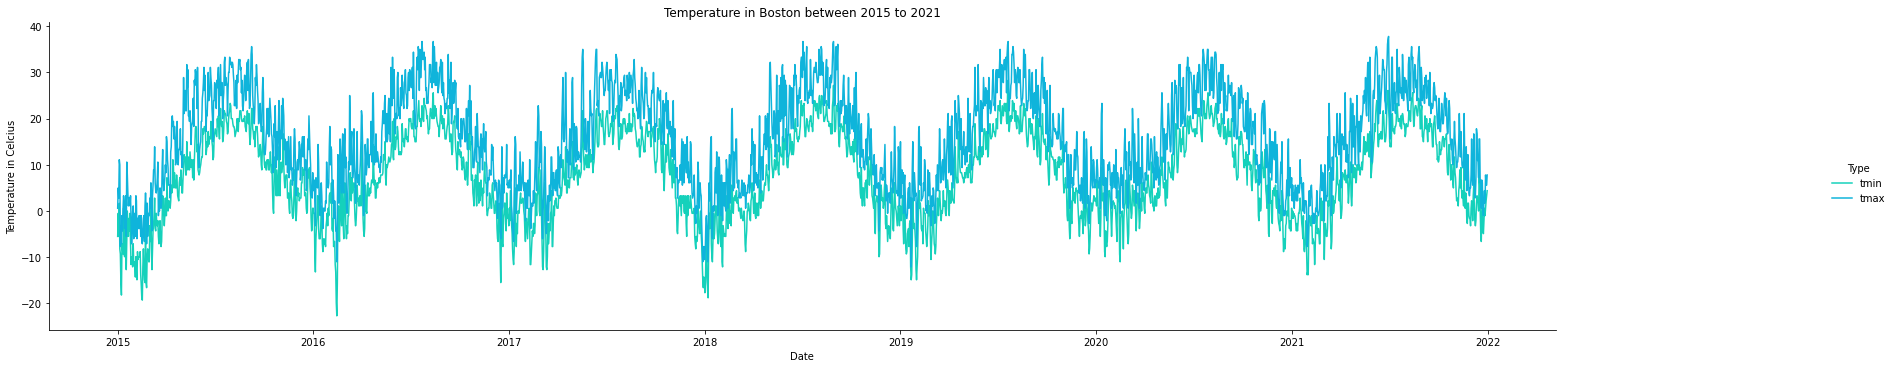

In [29]:
## Show weather over 2015 - 2021
selected_weather = weather2015_2021.loc[:, ['date','tmin','tmax']].melt(id_vars=["date"], var_name="Type", value_name="value")
selected_weather['date'] = pd.to_datetime(selected_weather['date'])
selected_weather['value'] = pd.to_numeric(selected_weather['value'], downcast='float')
selected_weather.head()
sns.set_palette(custom_palette)
i = sns.relplot(data=selected_weather, x="date", y="value", hue="Type", kind="line").set(title='Temperature in Boston between 2015 to 2021', xlabel='Date', ylabel='Temperature in Celcius')
i.fig.set_size_inches(30,5)

In [30]:
## Improve prediction module with more data from 2020 - 2021
parameters = bluebikes2015_2021_prediction[['tavg','prcp','wspd','day','month']]
result = bluebikes2015_2021_prediction['total']

model_reg_2015_2021 = LinearRegression()
model_reg_2015_2021.fit(parameters.values, result.values)
model_reg_2015_2021.score(parameters.values,result.values)

0.5303041791068688

In [31]:
## Load real bikes data in 2022 for testing
list_2022 = ['202201','202202','202203','202204','202205']

load = list()
for pre_file_name in list_2022:
  response = requests.get('https://s3.amazonaws.com/hubway-data/{}-bluebikes-tripdata.zip'.format(pre_file_name))
  zip = ZipFile(io.BytesIO(response.content))
  with zip.open('{}-bluebikes-tripdata.csv'.format(pre_file_name), mode="r") as csv_file:
    load.append(pd.read_csv(csv_file))
bluebikes_2022 = pd.concat(load)

## Load weather data 2022 for testing, and upload it to Github
weather_2022 = pd.read_csv('https://raw.githubusercontent.com/5RK7N/boston-bluebike/main/weather/BostonWeatherData2022_Jan_May.csv', index_col=False, dtype='unicode')

In [32]:
## Cleanup bluebike trip date and weather data in 2022
bluebikes_2022['starttime'] = pd.to_datetime(bluebikes_2022['starttime'])
bluebikes_2022['only_date'] = pd.to_datetime(bluebikes_2022.starttime.dt.date)
bluebikes_2022['start_station'] = pd.to_numeric(bluebikes_2022['start station id'], downcast='integer')

weather_2022['date'] = pd.to_datetime(weather_2022['date'])
weather_2022['tavg'] = pd.to_numeric(weather_2022['tavg'], downcast='float')
weather_2022['tmin'] = pd.to_numeric(weather_2022['tmin'], downcast='float')
weather_2022['tmax'] = pd.to_numeric(weather_2022['tmax'], downcast='float')
weather_2022['prcp'] = pd.to_numeric(weather_2022['prcp'], downcast='float')
weather_2022['wdir'] = pd.to_numeric(weather_2022['wdir'], downcast='float')
weather_2022['wspd'] = pd.to_numeric(weather_2022['wspd'], downcast='float')
weather_2022['pres'] = pd.to_numeric(weather_2022['pres'], downcast='float')

bluebikes_2022_usertype = bluebikes_2022.groupby([bluebikes_2022['only_date'],bluebikes_2022['usertype']]).size().to_frame('real_2022').reset_index()
bluebikes_2022_usertype = bluebikes_2022_usertype.pivot_table('real_2022', 'only_date', 'usertype').reset_index()
bluebikes_2022_total = bluebikes_2022.loc[:, ['tripduration','only_date','start_station','usertype']]
bluebikes_2022_total = bluebikes_2022_total.groupby(bluebikes_2022['only_date']).size().to_frame('real_2022').reset_index()
bluebikes_2022_all = pd.merge(left=bluebikes_2022_total, right=bluebikes_2022_usertype, how='left', left_on='only_date', right_on='only_date')

bluebikes2022_prediction = pd.merge(left=bluebikes_2022_all, right=weather_2022, how='left', left_on='only_date', right_on='date')
bluebikes2022_prediction['day'] = bluebikes2022_prediction.date.dt.dayofweek + 1
bluebikes2022_prediction['month'] = bluebikes2022_prediction.date.dt.month
bluebikes2022_prediction = bluebikes2022_prediction.loc[:, ['date','day','month','tavg','prcp','wspd','real_2022']]

bluebikes2022_prediction.head()

,date,day,month,tavg,prcp,wspd,real_2022
0,2022-01-01,6,1,7.7,2.0,5.400000,2123
1,2022-01-02,7,1,7.4,5.8,14.400000,1940
2,2022-01-03,1,1,-1.4,0.0,22.700001,2624
3,2022-01-04,2,1,-4.9,0.0,15.800000,2686
4,2022-01-05,3,1,2.8,3.0,18.000000,2617


In [33]:
## Apply test data to both models 
def testModel2021(data_object):
  num_pred = model_reg_2021.predict(np.array([data_object['tavg'], data_object['prcp'], data_object['wspd'], data_object['day'], data_object['month']]).reshape(1, -1))
  return int(round(num_pred[0],0))

def testModel2015_2021(data_object):
  num_pred = model_reg_2015_2021.predict(np.array([data_object['tavg'], data_object['prcp'], data_object['wspd'], data_object['day'], data_object['month']]).reshape(1, -1))
  return int(round(num_pred[0],0))

bluebikes2022_prediction['predict_2021'] = bluebikes2022_prediction.apply(testModel2021, axis='columns', result_type='expand')
bluebikes2022_prediction['predict_2015_2021'] = bluebikes2022_prediction.apply(testModel2015_2021, axis='columns', result_type='expand')
bluebikes2022_prediction = bluebikes2022_prediction.loc[:, ['date','real_2022','predict_2021','predict_2015_2021']]
bluebikes2022_plot = bluebikes2022_prediction.melt(id_vars=["date"], var_name="Type", value_name="Value").reset_index()
bluebikes2022_plot.head()

,index,date,Type,Value
0,0,2022-01-01,real_2022,2123
1,1,2022-01-02,real_2022,1940
2,2,2022-01-03,real_2022,2624
3,3,2022-01-04,real_2022,2686
4,4,2022-01-05,real_2022,2617


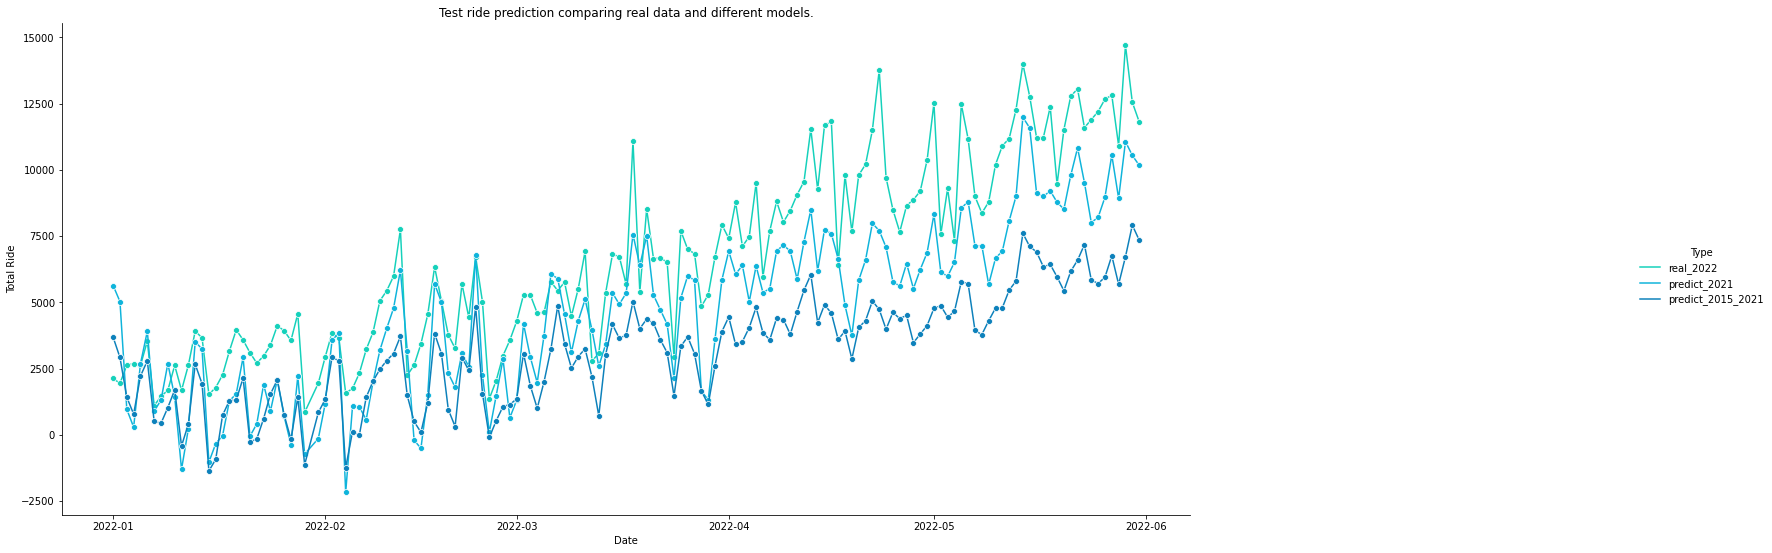

In [34]:
## Plot results from the models comapring to the real data in 2022
n = sns.relplot(data=bluebikes2022_plot, x="date", y="Value", kind="line", hue="Type", marker='o').set(title='Test ride prediction comparing real data and different models.', xlabel='Date', ylabel='Total Ride')
n.fig.set_size_inches(29,8)

In [35]:
## Get 5-day forecast data from Openweather 
## Source: https://openweathermap.org/forecast5

openweather_api = "https://api.openweathermap.org/data/2.5/forecast?lat=42.3656&lon=-71.0096&units=metric&appid=3f5e938e5949092c35dd9288b1a698c6"
respone = requests.get(openweather_api).json()
request_dt = dt.datetime.now()

forcast_list = list()
for record in respone['list']:
  tavg = record['main']['temp']
  prcp = record['pop']
  wspd = record['wind']['speed']
  dt_text = record['dt_txt']
  list_data = {'datetime':dt_text,'pre_tavg':tavg,'pre_prcp':prcp,'pre_wspd':wspd,'request_dt':request_dt}
  forcast_list.append(list_data)

forcast = pd.DataFrame(forcast_list)

In [36]:
## Cleanup forcast data
forcast['datetime'] = pd.to_datetime(forcast['datetime'])
forcast['date'] = forcast.datetime.dt.date
forcast['time'] = forcast.datetime.dt.time
forcast['pre_tavg'] = pd.to_numeric(forcast['pre_tavg'], downcast='float')
forcast['pre_prcp'] = pd.to_numeric(forcast['pre_prcp'], downcast='float')
forcast['pre_wspd'] = pd.to_numeric(forcast['pre_wspd'], downcast='float')

forcast.head()

,datetime,pre_tavg,pre_prcp,pre_wspd,request_dt,date,time
0,2022-07-07 21:00:00,25.680000,0.0,4.18,2022-07-07 18:16:20.779702,2022-07-07,21:00:00
1,2022-07-08 00:00:00,23.120001,0.0,4.91,2022-07-07 18:16:20.779702,2022-07-08,00:00:00
2,2022-07-08 03:00:00,19.700001,0.0,3.80,2022-07-07 18:16:20.779702,2022-07-08,03:00:00
3,2022-07-08 06:00:00,17.650000,0.0,2.53,2022-07-07 18:16:20.779702,2022-07-08,06:00:00
4,2022-07-08 09:00:00,18.790001,0.0,2.40,2022-07-07 18:16:20.779702,2022-07-08,09:00:00


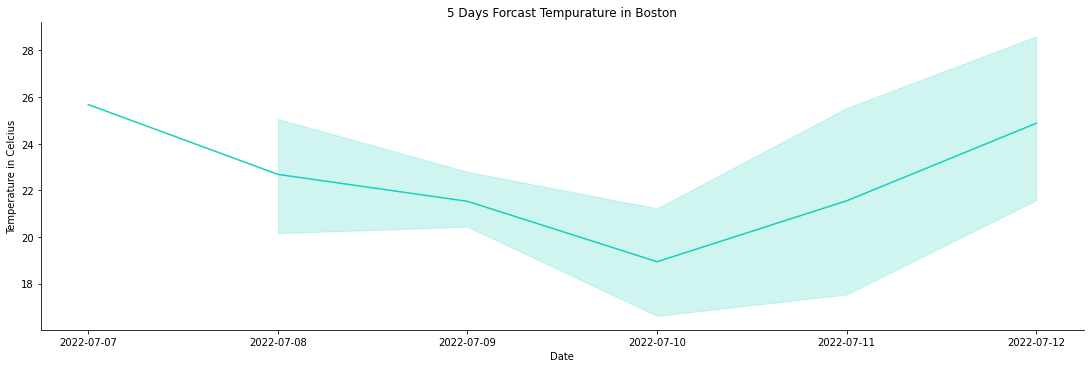

In [37]:
## Plot result from forecast data
l = sns.relplot(data=forcast, x="date", y="pre_tavg", kind="line").set(title='5 Days Forcast Tempurature in Boston', xlabel='Date', ylabel='Temperature in Celcius')
l.fig.set_size_inches(18,5)

In [38]:
## Aggregated forcast data per day
forcast_aggregated = forcast.groupby(['date']).agg({'pre_tavg':'mean','pre_prcp':'mean','pre_wspd':'mean','request_dt':'mean'}).reset_index()
forcast_aggregated['date'] = pd.to_datetime(forcast_aggregated['date'])
forcast_aggregated['day'] = forcast_aggregated.date.dt.dayofweek + 1
forcast_aggregated['month'] = forcast_aggregated.date.dt.month
forcast_aggregated.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6 entries, 0 to 5
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   date        6 non-null      datetime64[ns]
 1   pre_tavg    6 non-null      float32       
 2   pre_prcp    6 non-null      float32       
 3   pre_wspd    6 non-null      float32       
 4   request_dt  6 non-null      datetime64[ns]
 5   day         6 non-null      int64         
 6   month       6 non-null      int64         
dtypes: datetime64[ns](2), float32(3), int64(2)
memory usage: 392.0 bytes


In [39]:
## Function - get prediction number from forecast
def getPredictionNumnber(data_object):
  num_pred = model_reg_2021.predict(np.array([data_object['pre_tavg'], data_object['pre_prcp'], data_object['pre_wspd'], data_object['day'], data_object['month']]).reshape(1, -1))
  return int(round(num_pred[0],0))

forcast_aggregated['predict_total_ride'] = forcast_aggregated.apply(getPredictionNumnber, axis='columns', result_type='expand')
forcast_aggregated.head()

,date,pre_tavg,pre_prcp,pre_wspd,request_dt,day,month,predict_total_ride
0,2022-07-07,25.680000,0.00000,4.18000,2022-07-07 18:16:20.779702016,4,7,13493
1,2022-07-08,22.686251,0.00000,3.29125,2022-07-07 18:16:20.779702016,5,7,12777
2,2022-07-09,21.531250,0.12125,3.57500,2022-07-07 18:16:20.779702016,6,7,12618
3,2022-07-10,18.941250,0.00000,2.71625,2022-07-07 18:16:20.779702016,7,7,12049
4,2022-07-11,21.552500,0.00000,3.20250,2022-07-07 18:16:20.779702016,1,7,11396


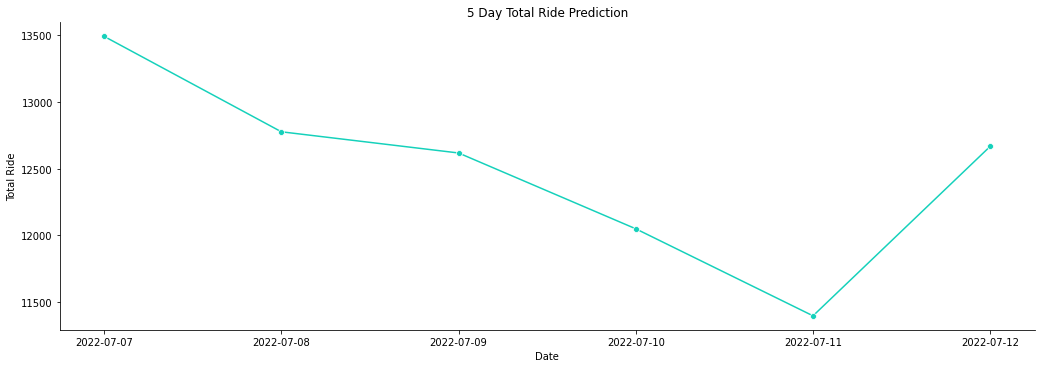

In [40]:
## Plot result of the prediction output with input from the forecast data
m = sns.relplot(data=forcast_aggregated, x="date", y="predict_total_ride", kind="line", marker='o').set(title='5 Day Total Ride Prediction', xlabel='Date', ylabel='Total Ride')
m.fig.set_size_inches(18,5)